In [1]:
%pip install opendatasets --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:08<00:00, 27.9MB/s] 


In [3]:
import os

def rename_files(root_dir):
    classes = os.listdir(root_dir)
    for classes in classes:
        for file in os.listdir(root_dir + '/' + classes): 
            if file.endswith('jpg') and classes not in file:
                os.rename((root_dir + '/' + classes + '/' + file),(root_dir + '/' + classes + '/' + classes + "_" + file))

root_dir = './flowers-recognition'
data_dir = f'{root_dir}/flowers'
print(os.listdir(data_dir))

rename_files(data_dir)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [4]:
from torch.utils.data import Dataset
from PIL import Image

def parse_species(fname):
    parts = fname.split('_')
    return parts[0]

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.files = []
        self.classes = [fname for fname in os.listdir(root_dir) if fname != 'flowers']
        for classes in self.classes:                         
            for file in os.listdir(root_dir + '/' + classes): 
                if file.endswith('jpg'):
                    self.files.append(file)
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        species = parse_species(fname)
        fpath = os.path.join(self.root_dir, species, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(species)
        return img, class_idx

In [5]:
import torchvision.transforms as T

img_size = 64
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transform = T.Compose([T.Resize((img_size, img_size)),
                       T.RandomCrop(64, padding=4, padding_mode='reflect'),
                       T.RandomHorizontalFlip(),
                       T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       T.ToTensor(),
                       T.Normalize(*stats,inplace=True)])
dataset = FlowersDataset(data_dir, transform=transform)

len(dataset)

4317

In [6]:
import torch
from torch.utils.data import random_split

random_seed = 43
torch.manual_seed(random_seed)

val_pct = 0.1
test_pct = 0.1
val_size = int(val_pct * len(dataset))
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size

train_ds, valid_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(valid_ds), len(test_ds)

(3455, 431, 431)

In [7]:
from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [9]:
device = get_default_device()
device

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ImageClassification(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)   
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)    
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))   
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),     
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))    
        
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [11]:
model = to_device(ImageClassification(3, 5), device)

In [12]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6107077598571777, 'val_acc': 0.18371841311454773}]

In [14]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [15]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00275, train_loss: 1.4340, val_loss: 1.9399, val_acc: 0.4583


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00757, train_loss: 1.3558, val_loss: 1.3827, val_acc: 0.4890


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.01000, train_loss: 1.4522, val_loss: 2.4179, val_acc: 0.3761


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00950, train_loss: 1.3815, val_loss: 1.0448, val_acc: 0.5942


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00812, train_loss: 1.1886, val_loss: 1.1594, val_acc: 0.6038


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00611, train_loss: 1.1859, val_loss: 1.0808, val_acc: 0.5990


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00389, train_loss: 1.0068, val_loss: 0.8924, val_acc: 0.6619


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00188, train_loss: 0.8344, val_loss: 0.8018, val_acc: 0.7000


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00050, train_loss: 0.7283, val_loss: 0.6960, val_acc: 0.7199


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 0.6887, val_loss: 0.6728, val_acc: 0.7384
CPU times: user 1h 20min 33s, sys: 7min 35s, total: 1h 28min 8s
Wall time: 15min 37s


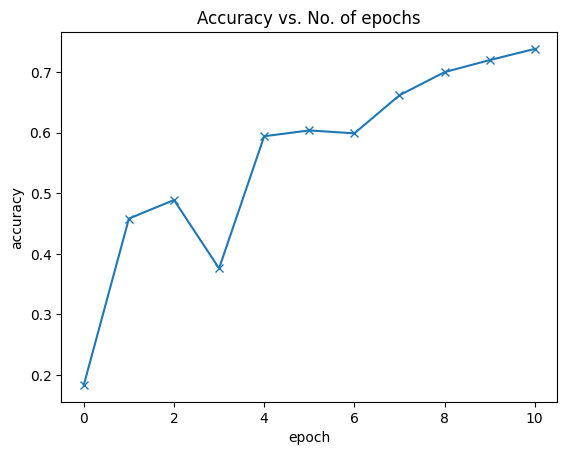

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

In [17]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

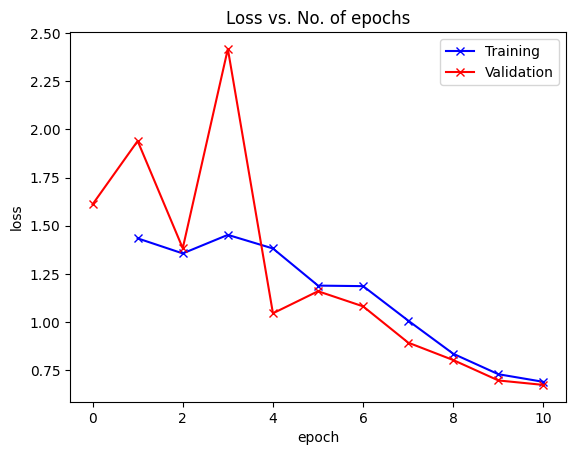

In [18]:
plot_losses(history)

In [19]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

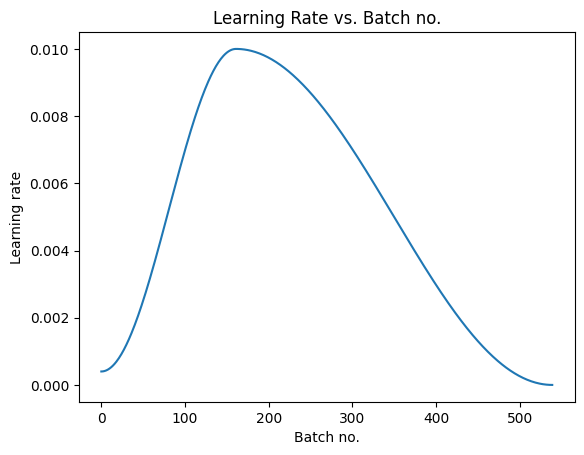

In [20]:
plot_lrs(history)

In [21]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [22]:
wrong, correct = 0, 0
for img, label in test_ds:
    if predict_image(img, model) == dataset.classes[label]:
        correct += 1
    else:
        wrong +=1

print("accuracy of test: %0.2f" % (correct / (wrong + correct)))

accuracy of test: 0.77
